In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter
plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.2.1


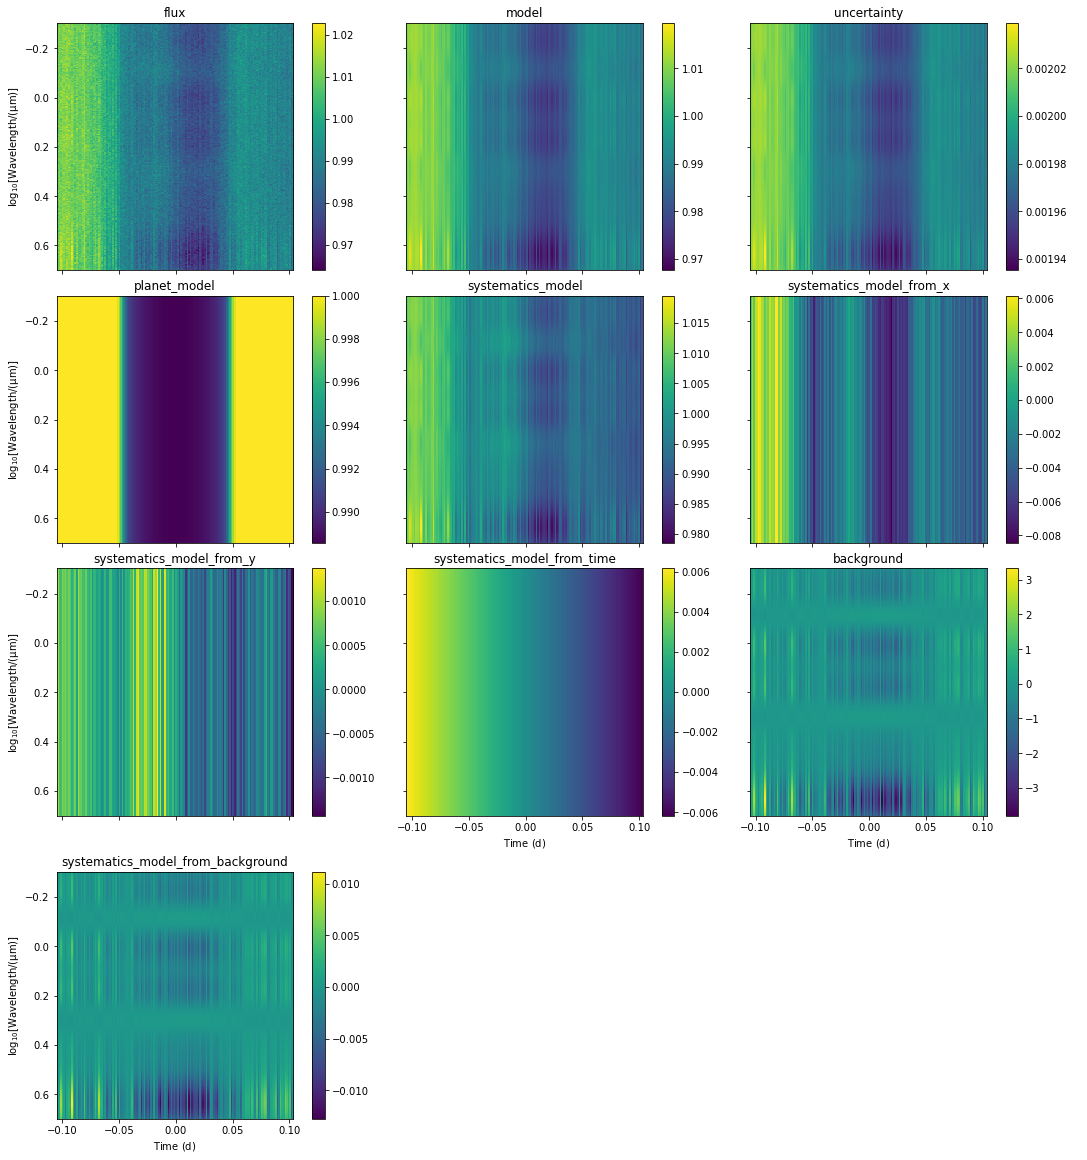

In [2]:
r_systematics = SimulatedRainbow().inject_transit().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500)
r_systematics.imshow_quantities();
r_systematics = r_systematics.bin(nwavelengths=int(r_systematics.nwave/5), dt=5 * u.minute)

In [3]:
# set up transit model:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
                )

# set up time polynomial model:
b = PolynomialModel(degree=1)
b.initialize_empty_model()
b.setup_parameters(
    p_1 = Fitted(Uniform,testval=0.0004,upper=0.005,lower=-0.005),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, indep_var="x")
b_x.initialize_empty_model()
b_x.setup_parameters(
    p_1 = Fitted(Uniform,testval=0.0004,upper=0.05,lower=-0.05),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, indep_var="y")
b_y.initialize_empty_model()
b_y.setup_parameters(
    p_1 = Fitted(Uniform,testval=0.001,upper=0.05,lower=-0.05),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, indep_var="background")
b_bkg.initialize_empty_model()
b_bkg.setup_parameters(
    p_1 = WavelikeFitted(Uniform,testval=0.002,upper=0.05,lower=-0.05),
)

In [4]:
## combine the models!
cm = CombinedModel()
cm.initialize_empty_model()
cm.attach_models({'transit':t,'time':b,'x':b_x,'y':b_y,'background':b_bkg})
cm.attach_data(r_systematics)
cm.setup_lightcurves()
cm.setup_likelihood()
print(cm.chromatic_models)
print(cm.pymc3_model)

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10015.05it/s]


{'transit': <experimental chromatic transit model 🌈>, 'time': <experimental chromatic polynomial model 🌈>, 'x': <experimental chromatic polynomial model 🌈>, 'y': <experimental chromatic polynomial model 🌈>, 'background': <experimental chromatic polynomial model 🌈>}
             transit_epoch_interval__ ~ TransformedDistribution
    transit_impact_parameter_impact__ ~ TransformedDistribution
    transit_stellar_radius_interval__ ~ TransformedDistribution
      transit_stellar_mass_interval__ ~ TransformedDistribution
transit_limb_darkening_quadlimbdark__ ~ TransformedDistribution
              transit_radius_ratio_w0 ~ Normal
          transit_baseline_interval__ ~ TransformedDistribution
              transit_radius_ratio_w1 ~ Normal
              transit_radius_ratio_w2 ~ Normal
              transit_radius_ratio_w3 ~ Normal
              transit_radius_ratio_w4 ~ Normal
                  time_p_1_interval__ ~ TransformedDistribution
                     x_p_1_interval__ ~ Transformed


🌈 Warning: invalid value encountered in log

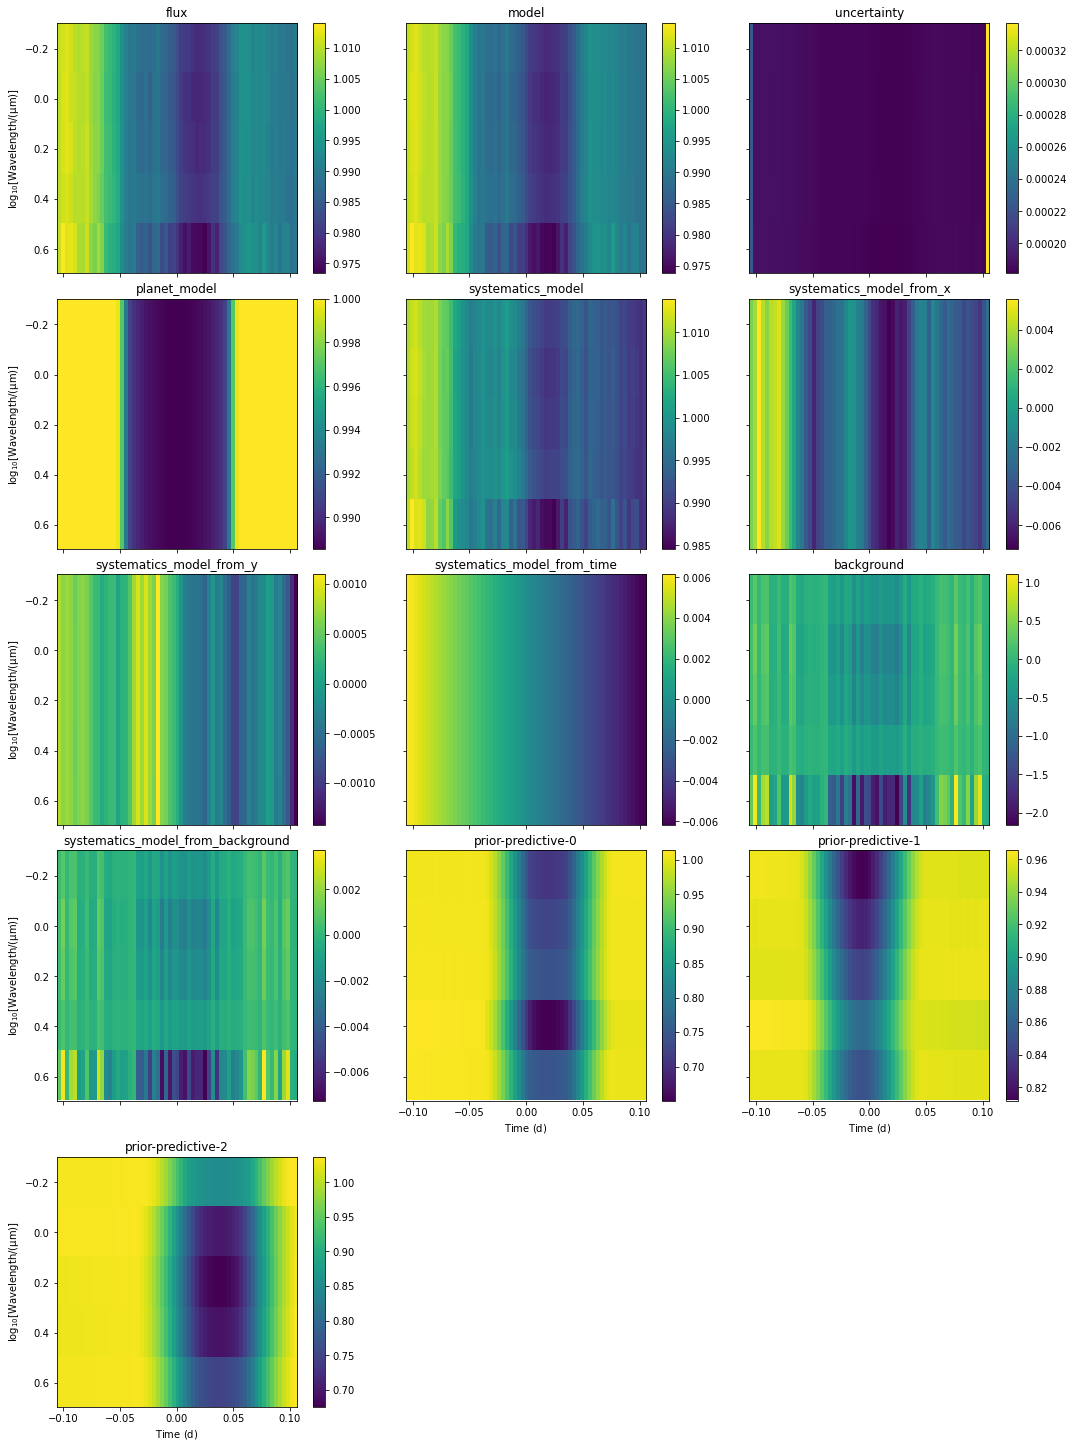

In [5]:
cm.plot_priors()

In [ ]:
opt = cm.optimize()
cm.sample(start=opt, tune=3000, draws=3000, cores=12, chains=4)
cm.summarize(round_to=7, fmt='wide')

In [ ]:
cm.plot_posteriors()